In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from sklearn.metrics import mean_absolute_error

from abnativ.model.alignment.blossum import distance_blosum_normalised
from abnativ.model.alignment import mybio


def perf_metrix(predictions, true_values):
    
    pearson, pearson_p = scipy.stats.pearsonr(predictions, true_values)
    spearman, spearman_p = scipy.stats.spearmanr(predictions, true_values)
    rmse = mean_absolute_error(predictions, true_values)
    
    pearson = float("{0:.3g}".format(pearson))
    pearson_p = float("{0:.3g}".format(pearson_p))
    spearman = float("{0:.3g}".format(spearman))
    spearman_p = float("{0:.3g}".format(spearman_p))
    rmse = float("{0:.3g}".format(rmse))
    
    return pearson, pearson_p, spearman, spearman_p, rmse




In [2]:
# Plot all test predictions with error bars
def plot_predwerr(df_to_plot, fp_fig_to_save, hue='clust_kmedoids_blosum', 
				fontsize=26 ,transparency=0.15,
				title = 'esm1b'):

	"""
	Plot predictions with error bars, and true values.
	Parameters
	----------
	df_to_plot: DataFrame containing columns 'tm' (true Tm), 
											'pred' (saved test predictions), 
											'error' (estimated error in predictions), 
											'expmethod_kmeans' (or other classification column).
	transparency: Transparency of error bars.
	"""

    # Extract data
	pred = df_to_plot['pred'].to_list()
	true_tm = df_to_plot['tm'].to_list()	

	# Calculate evaluation metrics
	pearson, pearson_p, spearman, spearman_p, rmse = perf_metrix(pred, true_tm)
	std_ratio = float("{0:.3g}".format(np.std(pred)/np.std(true_tm))) # ratio of std of predictions to std of true temperatures
	pred_error = [np.abs(pred[i]-true_tm[i]) for i in range(len(pred))]
	mae = np.mean(pred_error)

    # Plot error bars
	sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                        'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
	fig, ax = plt.subplots(figsize=(12, 12))
	palette="tab20"

	ax.plot([0,200], [0,200], '-', color='grey', alpha=0.4, linewidth=2)

	
	# Scatter plot of predictions
	plotscatter = sns.scatterplot(df_to_plot, x='tm', y='pred', hue=hue, palette=palette, ax=ax, alpha=0.9,s=70)


	for i in range(len(df_to_plot)):
		ax.errorbar(df_to_plot['tm'].iloc[i], df_to_plot['pred'].iloc[i], yerr=df_to_plot['std'].iloc[i], fmt='none', linewidth=2, alpha=0.2)
	

	# Set title and labels
	pearson_latex = r'$r$'
	spearman_latex = r'$\rho$'
	ax.set_ylabel('', fontsize=fontsize)
	ax.set_xlabel('', fontsize=fontsize)
	ax.set_xlim(22,102)
	ax.set_ylim(22,102)

	plt.tick_params(bottom=True, left=True, labelsize=22)
	
	legend = plt.legend(title='', ncol=3, fontsize=22, markerscale=2,
				loc='lower right' , handletextpad=0.1, columnspacing=1.0, frameon=False)

	plt.savefig(fp_fig_to_save, dpi=800, bbox_inches='tight', transparent=True)
	plt.show()
	plt.close()
	
	print(f'{title} \n{pearson_latex} = {pearson}, {spearman_latex} = {spearman}, RMSE = {rmse} \nprediction std/true temperatures std = {round(std_ratio,5)}, MAE = {round(mae,5)}\n')




Index(['id', 'al_seq', 'seq', 'esm1b', 'esm2_t30', 'ablang', 'vhse',
       'antiberty', 'onehot', 'nanobuilder', 'nanobert', 'exp_method', 'tm',
       'clust_kmedoids_blosum', 'expmeth_clust_kmedoids_blosum',
       'clust_kmeans_esm1b', 'expmeth_clust_kmeans_esm1b'],
      dtype='object')
Counter({2: 479, 4: 114, 3: 19, 5: 10, 0: 9, 6: 5, 1: 4})


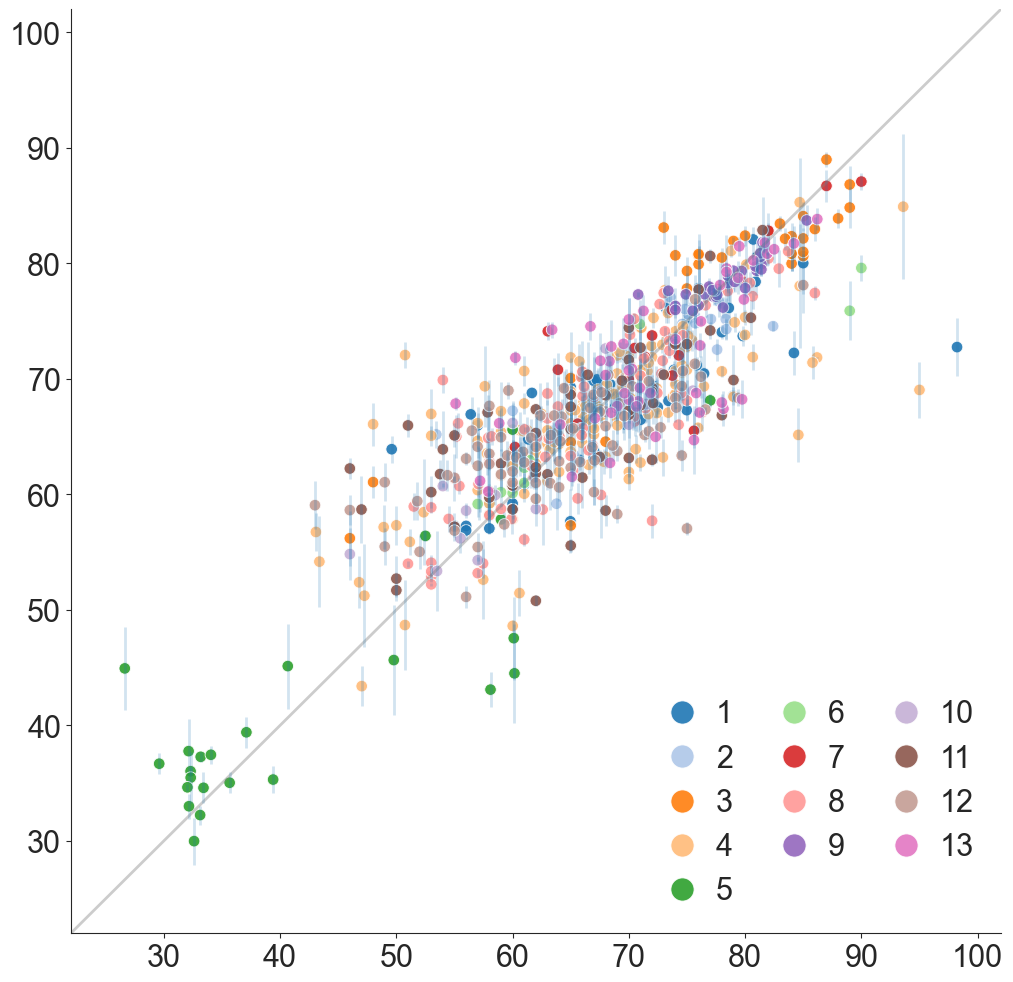

ensemble with ridge 
$r$ = 0.862, $\rho$ = 0.845, RMSE = 3.92 
prediction std/true temperatures std = 0.842, MAE = 3.91599

MEAN STD  1.250301138107472


In [3]:
from collections import Counter

# Code below not fully filled in; to be run with the right inputs
# Set up df_to_plot
# Insert csv file paths for saved predictions and errors
fp_database = "data/database_640.pkl"
fp_pred = "data/predictions_exp_blosum_640_mae_no_mean/ens_no_mean_spearman_div_emb.csv"

fp_fig_to_save = "figures/figure5.png"

df_embed = pd.read_pickle(fp_database)
df_pred = pd.read_csv(fp_pred)


seqs = df_embed['al_seq']
nb_c = [seq.count('C') for seq in seqs]

print(df_embed.columns)

# Insert here to extract predictions and errors here
all_predictions = df_pred[f"ridge_tm_4"].to_list()
predictions = [np.mean([float(p) for p in pred.split('_')]) for pred in all_predictions]
std_predictions = [np.std([float(p) for p in pred.split('_')]) for pred in all_predictions]

df_to_plot = df_embed.copy()
df_to_plot['pred'] = predictions
df_to_plot['std'] = std_predictions 
df_to_plot['nb_c'] = nb_c
print(Counter(nb_c))
df_to_plot.to_csv('results_pred_ens_indiv_exp.csv')
hue = 'clust_kmedoids_blosum' # 'clust_kmedoids_blosum' 'nb_c'

df_to_plot = df_to_plot.sort_values(by=hue)
df_to_plot[hue] = [str(x+1) for x in df_to_plot[hue]]

plot_predwerr(df_to_plot = df_to_plot, fp_fig_to_save = fp_fig_to_save, hue = hue, 
			  title = 'ensemble with ridge')

print('MEAN STD ', np.mean(std_predictions))


In [30]:
# Plot predictions for each cluster
def plot_pred_byclust(df_to_plot, fp_fig_to_save, 
					strat_method = "clust_kmedoids_blosum", fontsize = 14):
	"""
	Plot predictions for each cluster, with error bars and sequence distance matrix.
	Parameters
	----------
	df_to_plot: DataFrame containing columns 'tm' (true Tm),
											'aligned_seq' (aligned sequence),
											'pred' (saved test predictions),
											'error' (estimated error in predictions),
											'expmethod_kmeans' (or other classification column).
	"""

	

	# Sort df_to_plot by strat_method
	df_to_plot_sorted = df_to_plot.sort_values(by=strat_method)
	num_clust = df_to_plot_sorted[strat_method].nunique()

	pearsons, spearmans, rmses = [],[],[]
	clust_dist_mat = []
	clust_size = []

	# Colour map for clusters
	list_colors = sns.color_palette("colorblind",num_clust)		

	# Plot predictions for each cluster
	sns.set_theme(style='white')
	max = 7
	fig, axs = plt.subplots(max, 4, figsize=(18, 27))

	plt.rcParams['xtick.bottom'] = True
	plt.rcParams['ytick.left'] = True

	list_clust = [str(x) for x in np.arange(1,num_clust+1,1)]
	for k, clust in enumerate(list_clust):
		df_clust = df_to_plot_sorted[df_to_plot_sorted[f'{strat_method}']==clust].reset_index()
		clust=int(clust)-1
		
		if k < max:
			row = clust
			n_col_pred = 0
			n_col_dis = 1
		else:
			row = clust - max
			n_col_pred = 2
			n_col_dis = 3
		clust_pred = df_clust['pred'].to_list()
		clust_tm = df_clust['tm'].to_list()
		clust_err = df_clust['std'].to_list()		
		
		print(f"Cluster {clust}: ", df_clust.shape)
		
		# Plot predictions

		sns.scatterplot(df_clust, x='tm', y='pred', ax=axs[row,n_col_pred], color=list_colors[clust])
		axs[row,n_col_pred].plot(clust_tm, clust_tm, ':', color='lightsteelblue')

		# Plot error bars
		for k in range(len(df_clust)):
			axs[row,n_col_pred].errorbar(df_clust['tm'][k], df_clust['pred'][k], yerr=df_clust['std'][k], fmt='none', alpha=0.2)
		ploterror = axs[row,n_col_pred].errorbar([], [], yerr=0.1, fmt='none', alpha=0, label=' ')
		ploterror = axs[row,n_col_pred].errorbar([], [], yerr=0.1, fmt='none', alpha=0, label='Error Bars')
		ploterror = axs[row,n_col_pred].errorbar([], [], yerr=0.1, fmt='none', alpha=0.5, label='Predicted error')

		# Calculate evaluation metrics
		std_ratio = "{0:.3g}".format(np.std(clust_pred)/np.std(clust_tm))
		pearson, pearson_p, spearman, spearman_p, rmse = perf_metrix(clust_pred, clust_tm)
		err_spearman = float("{0:.3g}".format(scipy.stats.spearmanr(clust_err,[np.abs(clust_pred[m]-clust_tm[m]) for m in range(len(clust_tm))])[0]))

		pearsons.append(pearson)
		spearmans.append(spearman)
		rmses.append(rmse)
		clust_size.append(len(df_clust))

		# Set title and labels
		axs[row,n_col_pred].set_ylabel(f'Prediced melting temperature / °C', fontsize=fontsize)
		axs[row,n_col_pred].set_xlabel(f'Measured melting temperature / °C', fontsize=fontsize)
		axs[row,n_col_pred].tick_params(labelsize=fontsize)
		axs[row,n_col_pred].xaxis.set_tick_params(labelbottom=True)
		axs[row,n_col_pred].yaxis.set_tick_params(labelbottom=True)
		pearson_latex = r'$r$'
		spearman_latex = r'$\rho$'
		title_clust = r'$\mathbf{Cluster\ %s\ (%s\ seq)}$' % (clust+1, len(df_clust))
		axs[row,n_col_pred].set_title(f"{title_clust} \n{pearson_latex} = {pearson}, {spearman_latex} = {spearman} MAE = {rmse}C, SDR = {std_ratio}", y=1.01, fontsize=fontsize)

		# Plot sequence distance matrix
		aligned_seqs = df_clust['al_seq'].to_list()
		mat_for_dist = distance_blosum_normalised
		distance_mat = mybio.distance_matrix_from_aligned_sequences(aligned_seqs, matrix_for_distance=mat_for_dist, return_number_of_mutations=True)

		# Normalised nb of mutations with the average AHo length 
		norm_matrix_mut = np.zeros((distance_mat.shape))

		for i, seq_nb_mutsin in enumerate(distance_mat):
			for j, nb_mut in enumerate(seq_nb_mutsin):
				l = (len(aligned_seqs[i].replace('-',''))+len(aligned_seqs[j].replace('-','')))/2
				norm_matrix_mut[i,j] = nb_mut/l
		
		clust_dist_mat.append(np.mean(norm_matrix_mut))

		ax = sns.heatmap(norm_matrix_mut, cmap="YlGnBu", annot=False, square=True, ax=axs[row,n_col_dis], vmin=0, vmax=0.5)
		cbar = ax.collections[0].colorbar
		cbar.set_label('Sequence distance', rotation=270, labelpad=20)
		axs[row,n_col_dis].set_xticks(range(0,len(norm_matrix_mut),len(norm_matrix_mut)//8),range(0,len(norm_matrix_mut),len(norm_matrix_mut)//8),fontsize=fontsize)
		axs[row,n_col_dis].set_yticks(range(0,len(norm_matrix_mut),len(norm_matrix_mut)//8),range(0,len(norm_matrix_mut),len(norm_matrix_mut)//8),fontsize=fontsize)
		axs[row,n_col_dis].xaxis.set_tick_params(labelbottom=True)
		axs[row,n_col_dis].yaxis.set_tick_params(labelbottom=True)
		axs[row,n_col_dis].set_xlabel("Sequence index", fontsize=fontsize)
		axs[row,n_col_dis].set_ylabel("Sequence index", fontsize=fontsize)

	if len(list_clust)%max != 0:
		row += 1 
		axs[row,n_col_dis].axis('off')
		axs[row,n_col_dis].set_xticks([])  
		axs[row,n_col_dis].set_yticks([]) 
		axs[row,n_col_dis].spines['top'].set_visible(False)
		axs[row,n_col_dis].spines['right'].set_visible(False)
		axs[row,n_col_dis].spines['left'].set_visible(False)
		axs[row,n_col_dis].spines['bottom'].set_visible(False)

		axs[row,n_col_pred].axis('off')
		axs[row,n_col_pred].set_xticks([])  
		axs[row,n_col_pred].set_yticks([]) 
		axs[row,n_col_pred].spines['top'].set_visible(False)
		axs[row,n_col_pred].spines['right'].set_visible(False)
		axs[row,n_col_pred].spines['left'].set_visible(False)
		axs[row,n_col_pred].spines['bottom'].set_visible(False)
		
	plt.tight_layout()
	if fp_fig_to_save:
		plt.savefig(fp_fig_to_save, dpi=800, bbox_inches='tight')
	plt.show()
	plt.close()
	

	df_clust_eval = pd.DataFrame({'cluster': list_clust, 'clust_size': clust_size, 'pearson': pearsons, 'spearman': spearmans, 'rmse': rmses, 'mean_clust_dist': clust_dist_mat})
	return df_clust_eval



Cluster 0:  (55, 21)


->>> Compute distance


100%|██████████| 54/54 [00:00<00:00, 24990.89it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 55 sequences [only_first_N_sequences=False], took 0.004526853561401367 s


Cluster 1:  (19, 21)


->>> Compute distance


100%|██████████| 18/18 [00:00<00:00, 21448.15it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 19 sequences [only_first_N_sequences=False], took 0.0025238990783691406 s


Cluster 2:  (34, 21)


->>> Compute distance


100%|██████████| 33/33 [00:00<00:00, 27321.76it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 34 sequences [only_first_N_sequences=False], took 0.0030841827392578125 s


Cluster 3:  (163, 21)


->>> Compute distance


100%|██████████| 162/162 [00:00<00:00, 12953.77it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 163 sequences [only_first_N_sequences=False], took 0.017240047454833984 s


Cluster 4:  (25, 21)


->>> Compute distance


100%|██████████| 24/24 [00:00<00:00, 24714.78it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 25 sequences [only_first_N_sequences=False], took 0.0027260780334472656 s


Cluster 5:  (11, 21)


->>> Compute distance


100%|██████████| 10/10 [00:00<00:00, 13231.24it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 11 sequences [only_first_N_sequences=False], took 0.002148151397705078 s


Cluster 6:  (17, 21)


->>> Compute distance


100%|██████████| 16/16 [00:00<00:00, 18941.25it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 17 sequences [only_first_N_sequences=False], took 0.002396106719970703 s


Cluster 7:  (85, 21)


->>> Compute distance


100%|██████████| 84/84 [00:00<00:00, 20705.31it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 85 sequences [only_first_N_sequences=False], took 0.006994962692260742 s


Cluster 8:  (34, 21)


->>> Compute distance


100%|██████████| 33/33 [00:00<00:00, 28109.67it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 34 sequences [only_first_N_sequences=False], took 0.0030472278594970703 s


Cluster 9:  (13, 21)


->>> Compute distance


100%|██████████| 12/12 [00:00<00:00, 15001.98it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 13 sequences [only_first_N_sequences=False], took 0.0022552013397216797 s


Cluster 10:  (55, 21)


->>> Compute distance


100%|██████████| 54/54 [00:00<00:00, 25714.40it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 55 sequences [only_first_N_sequences=False], took 0.004432201385498047 s


Cluster 11:  (79, 21)


->>> Compute distance


100%|██████████| 78/78 [00:00<00:00, 21551.76it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 79 sequences [only_first_N_sequences=False], took 0.006514072418212891 s


Cluster 12:  (50, 21)


->>> Compute distance


100%|██████████| 49/49 [00:00<00:00, 25760.95it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 50 sequences [only_first_N_sequences=False], took 0.00414586067199707 s


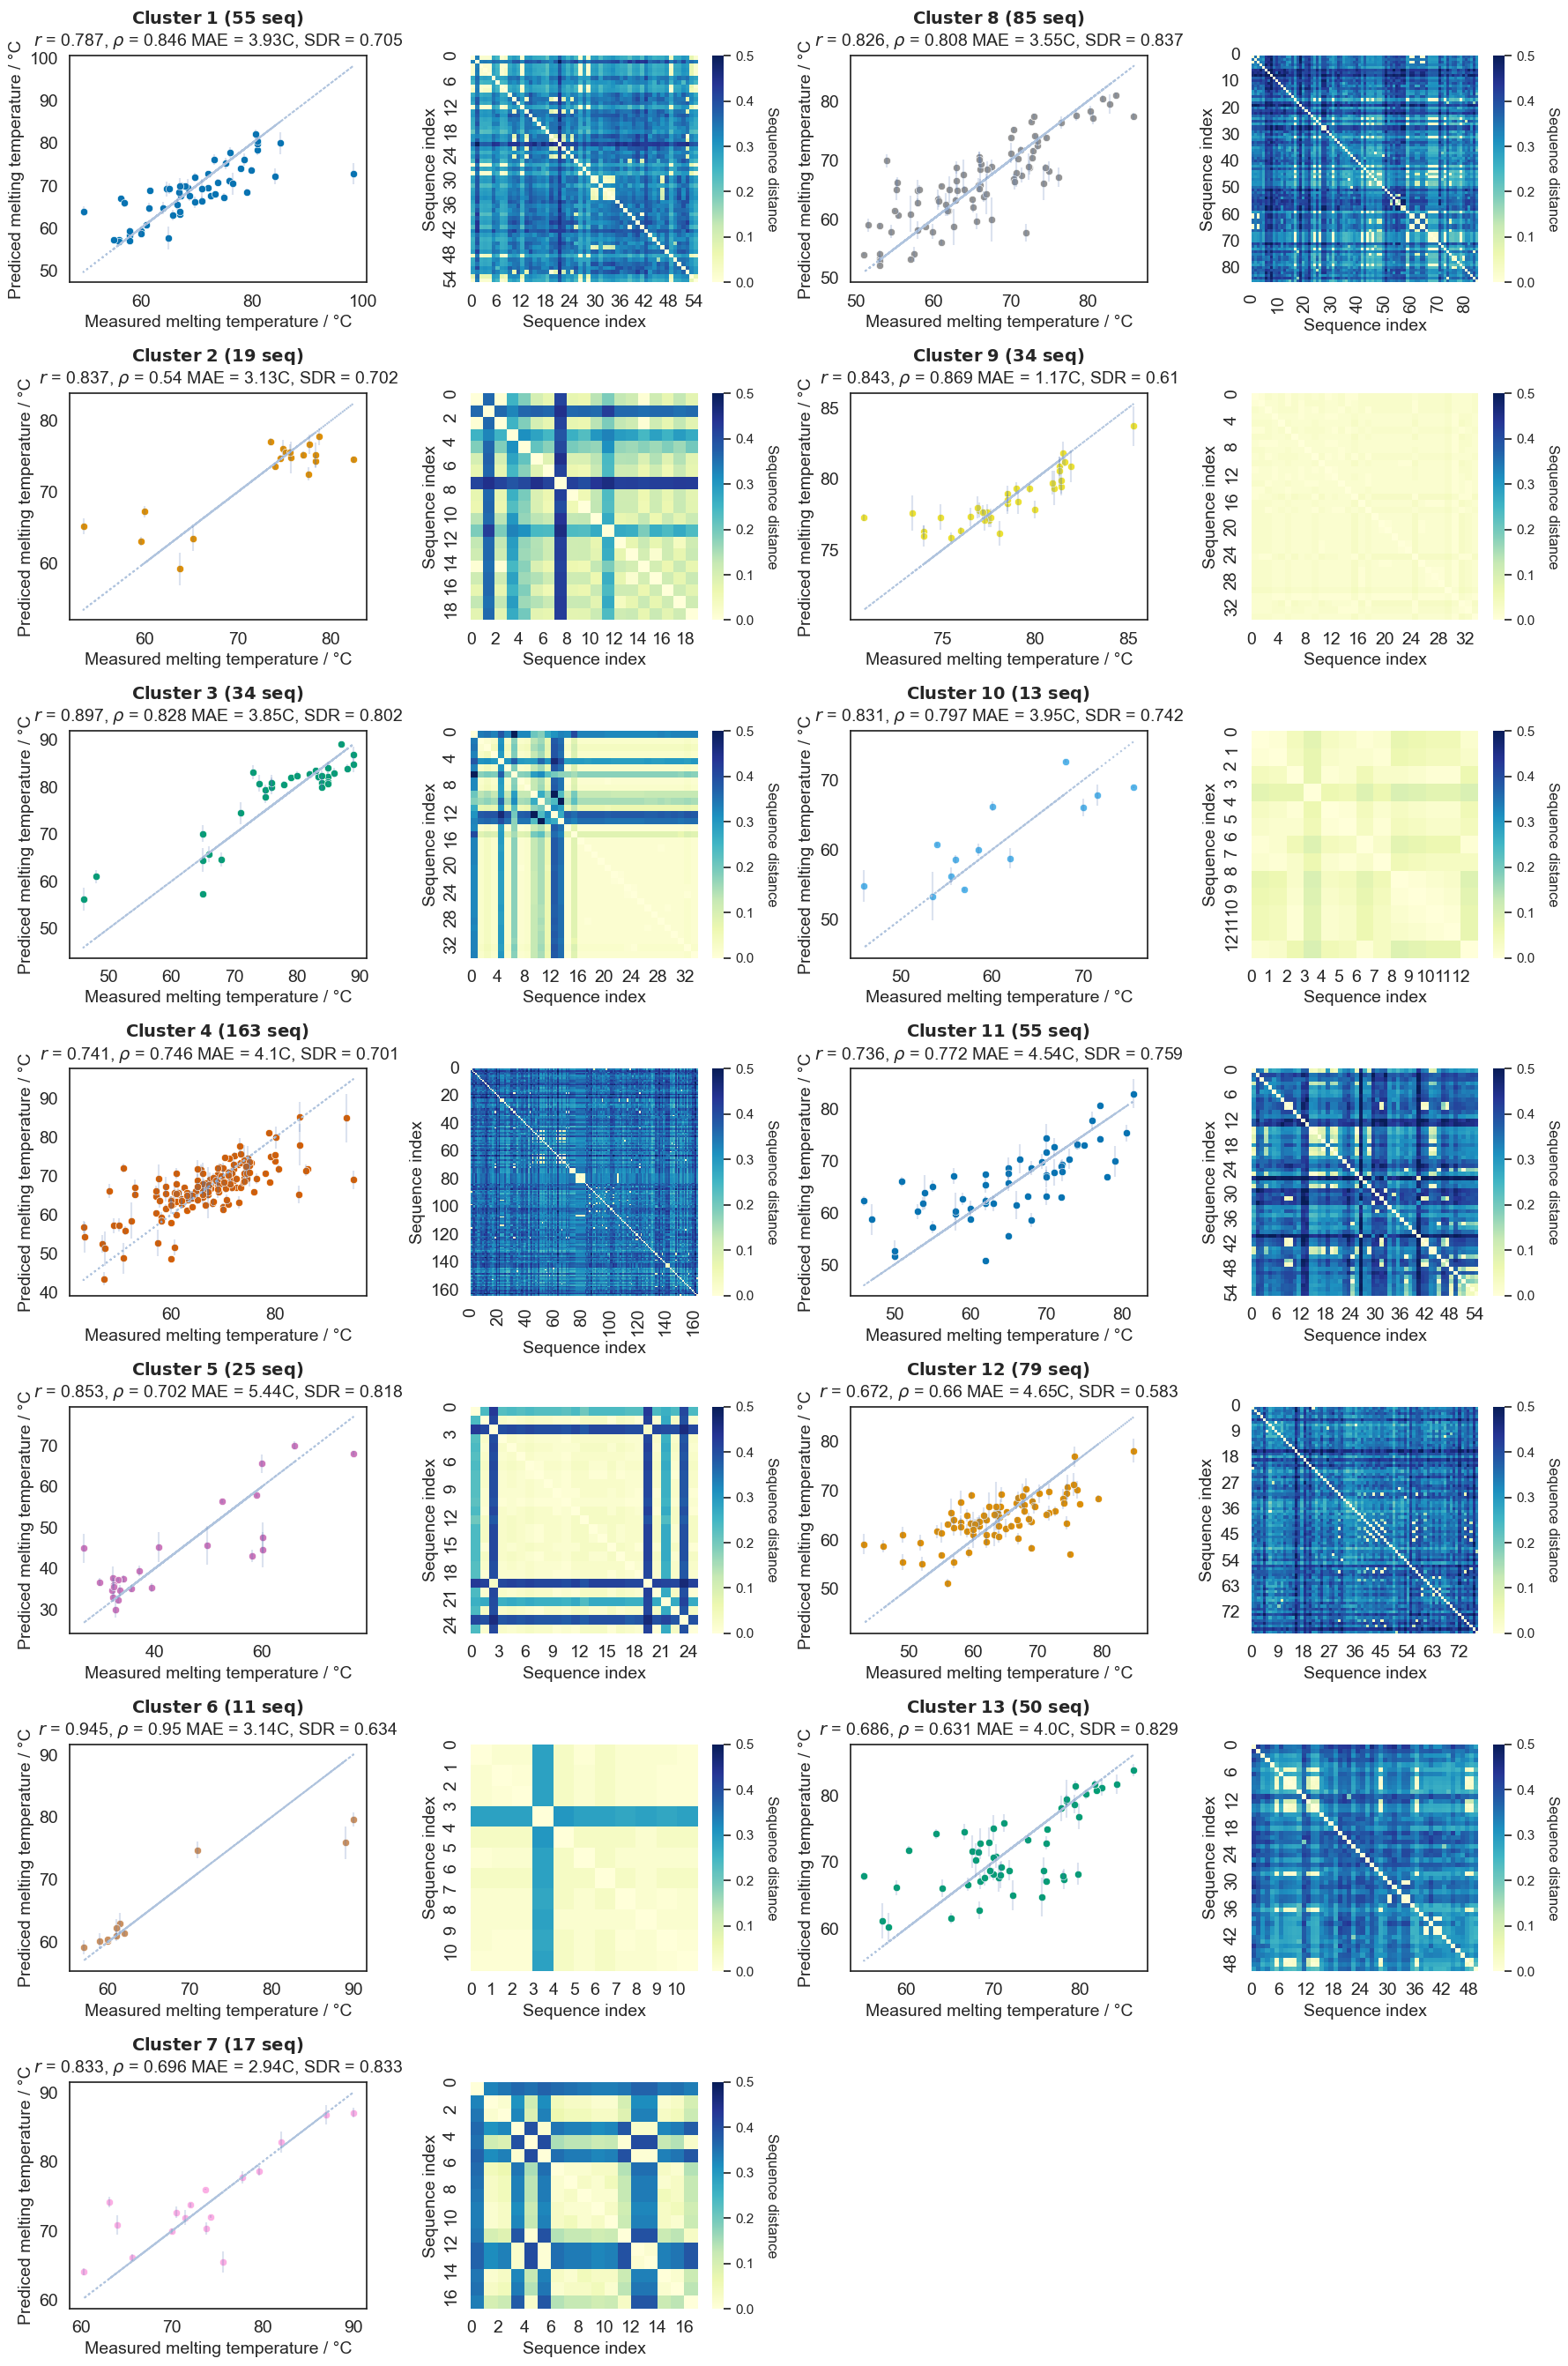

In [31]:
fp_fig_to_save = "figures/figureS9.png"
df_clust_eval = plot_pred_byclust(df_to_plot = df_to_plot, fp_fig_to_save=fp_fig_to_save, strat_method = "clust_kmedoids_blosum", fontsize = 14)



->>> Compute distance


100%|██████████| 639/639 [00:00<00:00, 3525.73it/s]

->Doing distance squareform
distance matrix and distance_n_mutations computed for 640 sequences [only_first_N_sequences=False], took 0.21680593490600586 s
dist  46.0


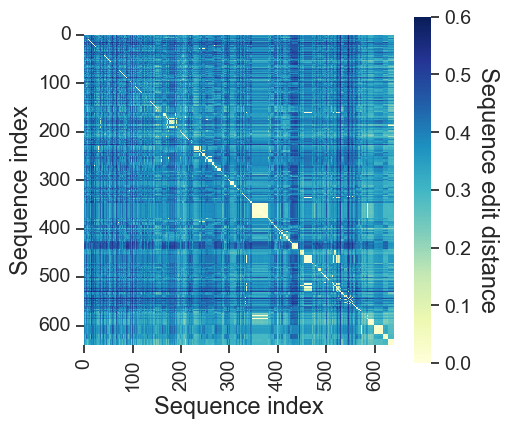

In [18]:
# Plot distance whole dataset
aligned_seqs = df_embed['al_seq'].to_list()
mat_for_dist = distance_blosum_normalised
distance_mat = mybio.distance_matrix_from_aligned_sequences(aligned_seqs, matrix_for_distance=mat_for_dist, return_number_of_mutations=True)

print('dist ', np.mean(distance_mat))

# Normalised nb of mutations with the average AHo length 
norm_matrix_mut = np.zeros((distance_mat.shape))

for i, seq_nb_mutsin in enumerate(distance_mat):
    for j, nb_mut in enumerate(seq_nb_mutsin):
        l = (len(aligned_seqs[i].replace('-',''))+len(aligned_seqs[j].replace('-','')))/2
        norm_matrix_mut[i,j] = nb_mut/l
		

sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                'xtick.bottom': True, 'ytick.left': True})
fig, ax = plt.subplots()
fig.set_size_inches(5,4.5)


ax = sns.heatmap(norm_matrix_mut, cmap="YlGnBu", annot=False, square=True,  vmin=0, vmax=0.6)
cbar = ax.collections[0].colorbar
plt.xticks(range(0,601,100),range(0,601,100),fontsize=14)
plt.yticks(range(0,601,100),range(0,601,100),fontsize=14)
cbar.set_label('Sequence edit distance', rotation=270, labelpad=20, fontsize=17)
cbar.ax.tick_params(labelsize=14) 
ax.set_xlabel("Sequence index", fontsize=17)
ax.set_ylabel("Sequence index", fontsize=17)

plt.savefig('figures/figureS6.png')